<center><font size = "10"> Week 12 - Network Simulation II and Extracellular recordings<center>
<center><font size = "8">Home Work <center>

<font size = "3">Please, write your group number and the names and surnames of the group members here
<br>Group number: 8
<br>Group member1: Chiara Maria Matti
<br>Group member2: Elena Grazia Gado
<br>Group member3: Eliser Josan Romero
    
__IMPORTANT:__<font size = "3"> Exercises in <font color='red'>red</font> are mandatory assignments to be delivered by next Monday before 23:59.


In [1]:
!nrnivmodl

/home/W12
Mod files: "./vecevent.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so
Successfully created x86_64/special


## Import libraries and classes

In [2]:
%matplotlib inline

import os
import random
import itertools
import numpy as np
import quantities as pq
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


from neuron import h, gui
from neo import SpikeTrain

import elephant.statistics as elstat
from elephant.conversion import BinnedSpikeTrain
import elephant.spike_train_correlation as elstc

from itertools import permutations
from scipy.signal import find_peaks
from matplotlib.collections import PolyCollection

import LFPy

# Load external files & initialize
h.load_file("stdrun.hoc")
h.stdinit()

sns.set_style("darkgrid")

--No graphics will be displayed.


[1702197917.086976] [noto:87   :0]       tcp_iface.c:865  UCX  ERROR opendir(/sys/class/net) failed: No such file or directory


In [3]:
class Cell:
    def __init__(self, filename, name, cell_type):
        self.name = name
        self.type = cell_type
        self.synapses = []
        self.build_morphology(filename)
        self.biophysics()

    def build_morphology(self, filename):
        h.load_file("import3d.hoc")
        h.load_file("stdlib.hoc")
        # morph_reader = h.Import3d_Neurolucida3()
        morph_reader = h.Import3d_SWC_read()
        morph_reader.input(filename)
        i3d = h.Import3d_GUI(morph_reader, 0)
        i3d.instantiate(
            self
        )  # Notice this change to be able to instantiate several cells

    def biophysics(self):
        for sec in h.allsec():
            sec.Ra = 100  # Axial resistance in Ohm * cm
            sec.cm = 1  # Membrane capacitance in micro Farads / cm^2
            sec.insert("pas")
            for seg in sec:
                seg.pas.g = 0.00003
                seg.pas.e = -75

        # Insert passive current in the dendrite
        for sec in self.soma:
            sec.insert("hh")
            for seg in sec:
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2

        if hasattr(self, "apic"):
            for sec in self.apic:
                sec.insert("hh")
                for seg in sec:
                    seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                    seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2

        for sec in self.dend:
            sec.insert("hh")
            for seg in sec:
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2

        for sec in self.axon:
            sec.insert("hh")
            for seg in sec:
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2

In [4]:
# connect two cells with an exponential synapse at given locations
# returns the netcon
def connect(
    source,
    target,
    weight=None,
    delay=5,
    source_sec=None,
    source_neurite="axon",
    target_sec=None,
    target_neurite="dend",
):
    rng = np.random.default_rng()

    if weight is None:
        weight = rng.uniform()  # random weight

    target_neurite_ = getattr(target, target_neurite)
    if target_sec is None:
        target_sec = rng.integers(0, len(target_neurite_))  # random dendritic section

    source_neurite_ = getattr(source, source_neurite)
    if source_sec is None:
        source_sec = rng.integers(0, len(source_neurite_))  # random axonal section

    target_syn = h.ExpSyn(target_neurite_[target_sec](0.5))
    target.synapses.append(target_syn)  # store synapse

    netcon = h.NetCon(
        source_neurite_[source_sec](0.5)._ref_v,
        target_syn,
        sec=source_neurite_[source_sec],
    )
    netcon.weight[0] = weight
    netcon.delay = delay
    # print(
    #     f"Connected cells {source.name} -> {target.name} with weight {weight} and delay {delay}, from {source_neurite}[{source_sec}] to {target_neurite}[{target_sec}]"
    # )

    return netcon


def spike_detector(voltage, threshold):
    # convert Neuron recording (voltage) to list
    voltage_read = []
    for v in voltage:
        voltage_read.append(v)
    # peak locations
    spike_time, _ = find_peaks(voltage_read, height=threshold)
    return spike_time


def generate_irregular_spiketrain(t_start, size):
    """generates irregular spike train with random inter-spike interval from the range between 10 and 50 ms"""
    stim_times = [t_start]
    for t in np.arange(size):
        n = np.random.randint(10, 50)
        step = stim_times[-1] + n
        stim_times.append(step)

    return stim_times


def place_exp_synapse(cell, tau=2, section=None):
    if not section:
        section = random.randint(0, len(cell.dend) - 1)
    synapse = h.ExpSyn(cell.dend[section](0.5))
    synapse.tau = tau  # ms
    # print(f"Stimulus apply in basal section num {section} of {cell.name}")
    return synapse, section


def simulate(cells, tstop=600):
    """This function simulates the network and return recordings of all cells
    put as argument."""
    cell_recordings = []
    for cell in cells:
        recording = cell
        cell_recordings.append(recording)

    soma_recordings = []
    for recording in cell_recordings:
        soma_v = h.Vector().record(recording.soma[0](0.5)._ref_v)
        soma_recordings.append(soma_v)

    time = h.Vector().record(h._ref_t)

    h.finitialize(-65)
    h.continuerun(tstop)

    return time, soma_recordings

# <font color= 'red'>Ex 1:</font> Network activity analysis 

<font size='3'> Load the five morphology reconstructions assigned to your group in week 7, using the class `Cell` defined in the tutorials. 
Connect the neurons with following weights:
- `w(Pyr - Pyr) = 1`
- `w(Pyr - Int) = 1`
- `w(Int - Pyr) = -0.01`
- `w(Int - Int) = -0.01`

<font size='3'>Add exponential synapses to random section of the basal dendrite of each cell (synapse `weight = 1.0` and `tau = 2`). Connect different Poisson spike trains to each of the exponential synapses (NOTE: this is asynchronous stimulation, a different poisson for each cell).   Run the simulation for 300 ms,  and show the voltage and spike plots neurons and Poisson input.

<font size='3'>Using the `elephant` library calculate:
    
<font size='3'>1. Pairwise __correlation coefficients__ and __covariance__ between the pairs of 5 neurons. Describe how covariance and correlation coefficient are calculated for neural spiking data. 

<font size='3'>2. the features MFR, CV, ISI for each cell. Compare these between the pyramidal cells and interneurons using a box plot. 
  
<font size='3'>Hint: Make sure to represent both spike trains in ms.

For each feature and each pair of cells, plot the normalized difference in the feature against their correlation coefficient on a scatter plot.
    
<font size='3'><font color= 'red'>[2.5pts]</font>

<span style="color:purple">
<font size='3'> 
    

## **Grading**: 
- [0.5 pt] for simulation setup
- [1 pt] for calculation and visualization of covariance and correlation
- [1 pt] for explaining covariance and correlation
- [0.5 pt] for explanation of differences between covariance and correlation 

[/2.5 pt]
</span>

## Answer
Describe how covariance and correlation coefficient are calculated for neural spiking data:
> Correlation coefficient and covariance are calulated by first splitting the spiketrains into bins of particular time lengths.
The number of spikes in each bin for each cell can then be treated as a vector, and covariance and correlation coeffficient calculated by the following formulae:
$$Cov(x, y) = \frac{(x - \bar{x}) \dot (y - \bar{y})}{N-1}$$ where $\bar{a}$ represents the mean of vector $a$ and $N$ is the sample size (in this case, number of time bins)
$$corr(x,y) = \rho(x, y) = \frac{Cov(x, y)}{\sigma_x \sigma_y} $$ where $\sigma_a$ represents the covariance of a vector $a$

> Both covariance and correlation measure the relationship and the dependency between two variables because the correlation is defined by the covariance divided by the square-root of the multiplication of the variance of x and y (where $var = \sigma^2$). However they differ in some aspect. Indeed, Covariance indicates the direction of the linear relationship between variables and Correlation measures both the strength and direction of the linear relationship between two variables. Plus because correlation is divided by $\sigma_x\sigma_y$, it is standardized compare to the covariance.

In [5]:
morph_path =[]
for file in os.listdir():
    if ".swc" in file:
        morph_path.append(file)

morph_path = sorted(morph_path)
for i in range(2):
    morph_path.append(morph_path.pop(0))
morph_path

['Pyr_01.swc', 'Pyr_02.swc', 'Pyr_03.swc', 'Int_01.swc', 'Int_02.swc']

In [6]:
cells = []
cells_Pyr = []
cells_Int = []
for cell_path in morph_path:
    if "Pyr" in cell_path:
        cell_type = "Pyr"
        cell_name = cell_path.split(".")[0]
        cell = Cell(cell_path, cell_name, cell_type)
        cells_Pyr.append(cell)
    else:
        cell_type = "Int"
        cell_name = cell_path.split(".")[0]
        cell = Cell(cell_path, cell_name, cell_type)
        cells_Int.append(cell)
    cells.append(cell)
cells

In [7]:
recording_cells = [cell for  cell in cells]
recording_cells_name = [x.name for x in cells]
recording_cells_name

['Pyr_01', 'Pyr_02', 'Pyr_03', 'Int_01', 'Int_02']

In [8]:
syn_weight = 1.0

netcons = []  # save the netcons in case we want to modify them later

for n, (pre_neuron, post_neuron) in enumerate(permutations(cells, 2)):
    if pre_neuron.type == "Pyr" and post_neuron.type == "Pyr":
        nc = connect(pre_neuron, post_neuron, weight=1.0)
        netcons.append(nc)
    elif pre_neuron.type == "Pyr" and post_neuron.type == "Int":
        nc = connect(pre_neuron, post_neuron, weight=1.0)
        netcons.append(nc)
    elif pre_neuron.type == "Int" and post_neuron.type == "Pyr":
        nc = connect(pre_neuron, post_neuron, weight=-0.01, target_neurite="soma")
        netcons.append(nc)
    elif pre_neuron.type == "Int" and post_neuron.type == "Int":
        nc = connect(pre_neuron, post_neuron, weight=-0.01, target_neurite="soma")
        netcons.append(nc)

synapses = []
for cell in cells:
    syn, _ = place_exp_synapse(cell, section=5)
    synapses.append(syn)


stimulators = []
connections = []
spike_trains = []
for syn in synapses:
    spike_train = np.random.exponential(20,size=1000).cumsum()
    spike_train = spike_train[spike_train < 300]
    spike_trains.append(spike_train)
    spikes_vector = h.Vector(spike_train)

    stimulators.append(h.VecStim())
    stimulators[-1].play(spikes_vector)

    connection = h.NetCon(stimulators[-1], syn)
    connection.weight[0] = syn_weight
    connections.append(connection)

time, recordings = simulate(cells)

In [9]:
spikes = []
for trace, cell in zip(recordings, cells):
    spikes.append(spike_detector(trace, -20.0))

spikes = np.asarray(spikes, dtype = "object") * 0.025

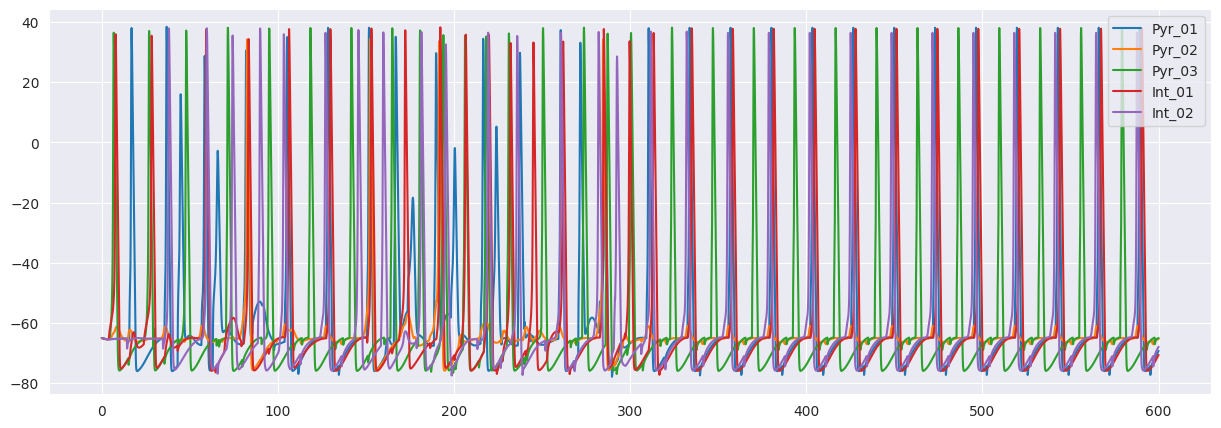

In [10]:
plt.figure(figsize=(15, 5))

for trace, cell in zip(recordings, cells):
    plt.plot(time, trace, label=cell.name)

plt.legend()

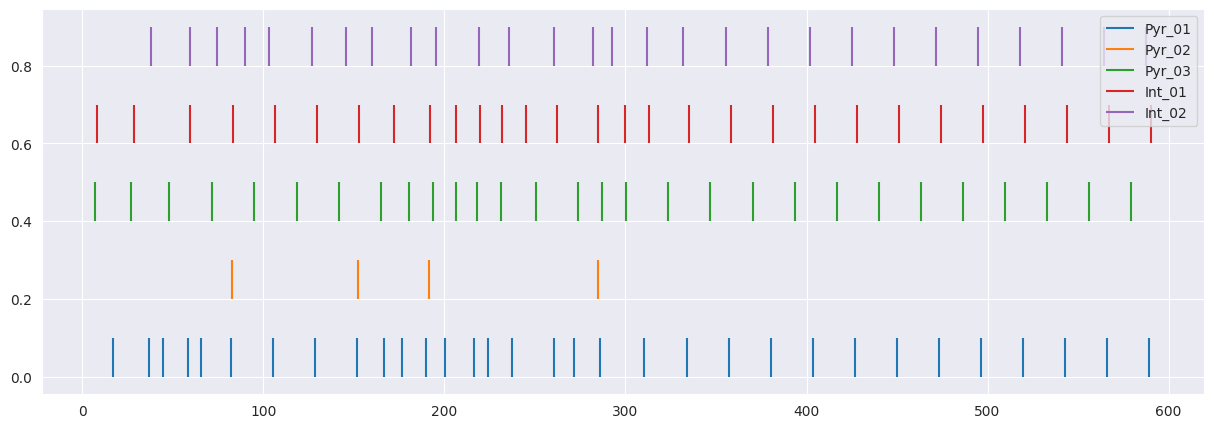

In [11]:
plt.figure(figsize=(15, 5))
for n, (spiketrain, cell) in enumerate(zip(spikes, cells)):
    plt.vlines(
        spiketrain, ymin=n * 0.2, ymax=n * 0.2 + 0.1, label=cell.name, color=f"C{n}"
    )

plt.legend()

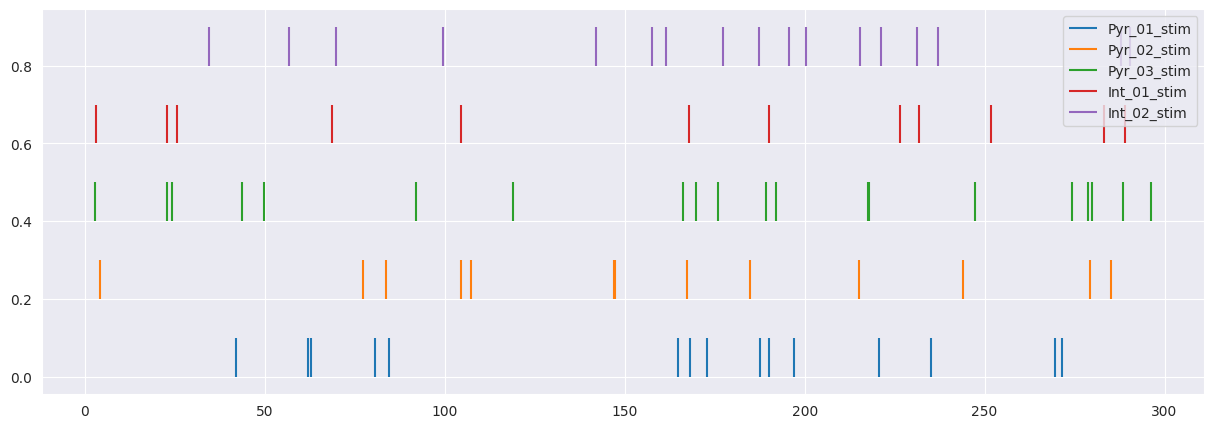

In [12]:
plt.figure(figsize=(15, 5))
for n, (spiketrain, cell) in enumerate(zip(spike_trains, cells)):
    plt.vlines(
        spiketrain,
        ymin=n * 0.2,
        ymax=n * 0.2 + 0.1,
        label=cell.name + "_stim",
        color=f"C{n}",
    )

plt.legend()

In [13]:
def extract_spiketrains_features(spikes):
    ISI = np.array([])
    FR = []
    CV = []

    for spiketrain in spikes:
        fr = elstat.mean_firing_rate(spiketrain) * 1000
        isi = elstat.isi(spiketrain)
        cv = elstat.cv(isi)
        FR.append(fr)
        CV.append(cv)
        ISI = np.append(ISI, isi)

    CV = np.array(CV)
    FR = np.array(FR)

    return {"CV": CV, "FR": FR, "ISI": ISI}

In [14]:
values = extract_spiketrains_features(spikes)

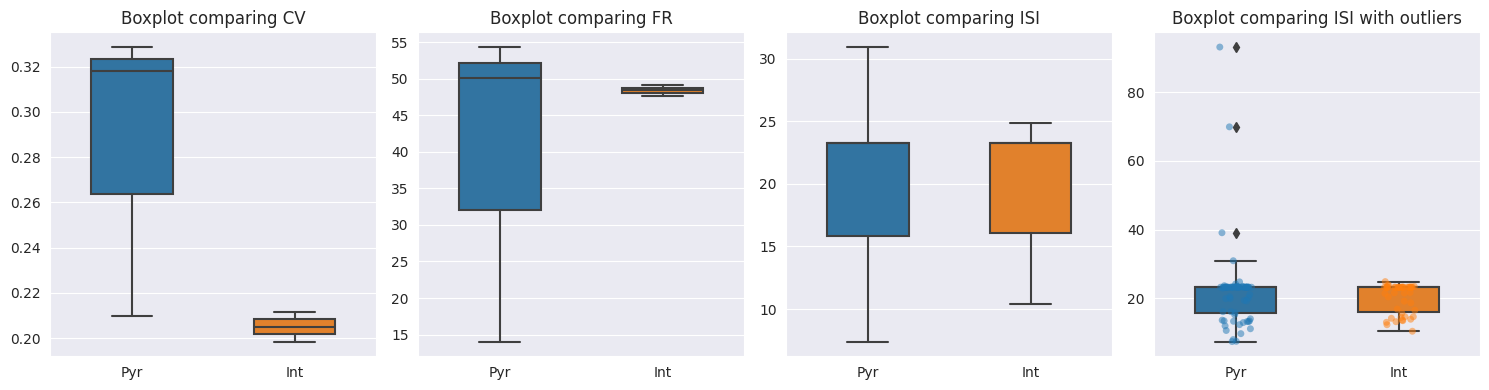

In [15]:
features = ['CV', 'FR', 'ISI']
fig, axs = plt.subplots(1, len(features)+1, figsize= (15,4))
cell_types = ['Pyr', 'Int']
for i, feature in enumerate(features):
    if feature == 'ISI':
        #need cutoff because ISI is have more than 1 value per cell
        val = values[feature]
        cut_off = int(((len(values[feature]) + 1)/ 5) * 3)
        # display without outliers for visibility
        sns.boxplot([values[feature][:cut_off], values[feature][cut_off:]], ax= axs[i], width=0.5, showfliers=False).set_xticks([0,1], cell_types)
        # display true data of ISI
        sns.boxplot([values[feature][:cut_off], values[feature][cut_off:]], ax= axs[i+1], width=0.5).set_xticks([0,1], cell_types)
        axs[i+1].set_title(f"Boxplot comparing {feature} with outliers")
        sns.stripplot([values[feature][:cut_off], values[feature][cut_off:]],ax = axs[i+1], marker="o", alpha=0.5)
    else:
        sns.boxplot([values[feature][:3], values[feature][3:]], ax= axs[i], width=0.5).set_xticks([0,1], cell_types)
        #sns.stripplot([values[feature][:3], values[feature][3:]],ax = axs[i], marker="o", alpha=0.5, color="black")
    axs[i].set_title(f"Boxplot comparing {feature}")
plt.tight_layout()
plt.show()

### Correlation coefficient and covariation

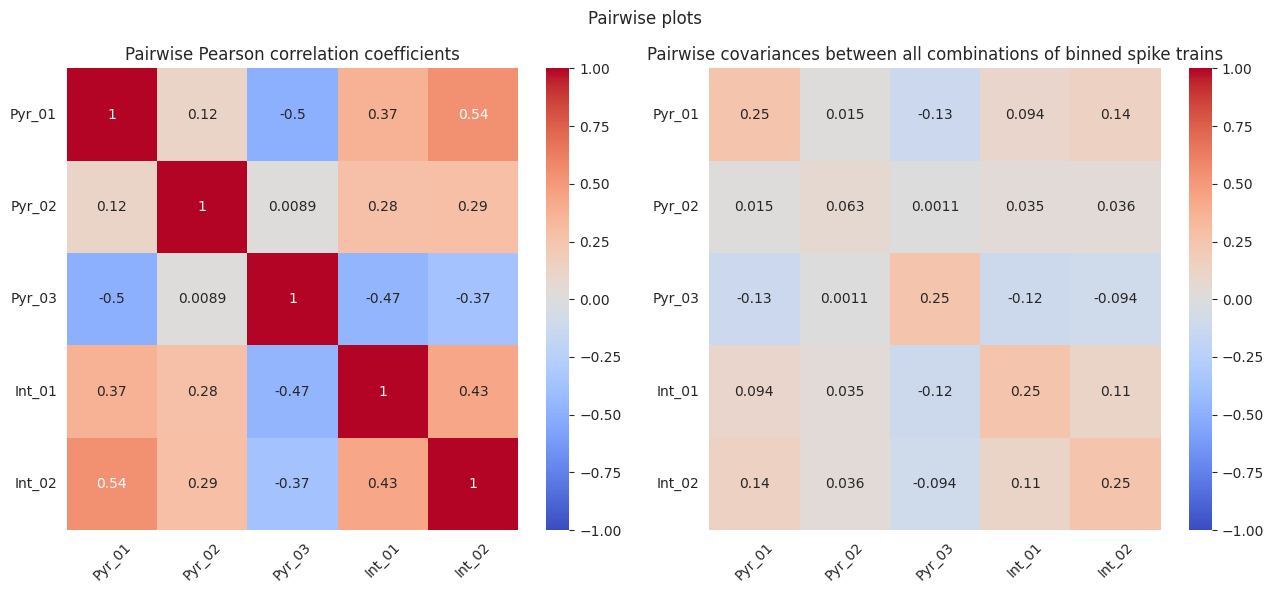

In [16]:
sim_tstop = 600

# We bin the spikes in both cell and stim spikes
allspikes = [SpikeTrain(x * pq.ms, t_stop=sim_tstop * pq.ms) for x in spikes]
binned_spikes = BinnedSpikeTrain(allspikes, binsize=10 * pq.ms)  # 10 ms bin
# Correlation coefficient matrix between all spike trains
cc = elstc.corrcoef(binned_spikes)
cv = elstc.covariance(binned_spikes)
fig, axs = plt.subplots(1, 2, figsize= (13,6))
fig.suptitle("Pairwise plots")
h1 =sns.heatmap(np.round(cc,4), annot= True, cmap="coolwarm", vmin=-1.0, vmax=1.0, 
            ax = axs[0], xticklabels = recording_cells_name, yticklabels= recording_cells_name)
h1.set_yticklabels(h1.get_yticklabels(), rotation=0)
h1.set_xticklabels(h1.get_xticklabels(), rotation=45)
axs[0].set_title("Pairwise Pearson correlation coefficients")

h2 = sns.heatmap(np.round(cv,4), annot= True, cmap="coolwarm", vmin=-1.0, vmax=1.0, 
            ax = axs[1], xticklabels = recording_cells_name, yticklabels= recording_cells_name)
h2.set_yticklabels(h2.get_yticklabels(), rotation=0)
h2.set_xticklabels(h1.get_xticklabels(), rotation=45)
axs[1].set_title("Pairwise covariances between all combinations of binned spike trains")
plt.tight_layout()
plt.show()

# <font color= 'red'>Ex 2:</font> Extracellular field

<font size='3'>Choose one pyramidal cell and one inhibitory cell from your set of cells. Run the code from tutorial 02 for each of the cells and compare the resulted response field for each of them. Explain what differences you see in the shapes and timecourses of the electrical fields recorded. What do these differences suggest about the patterns of transmembrane currents in the cells?

<font size='3'><font color= 'red'>[2.5 pts]</font>   



<span style="color:purple">
<font size='3'> 
    

## **Grading**: 
- [1 pt] for correct simulation setup and visualization
- [1 pt] for plots explanation

[/2.5 pt]    
</span>

In [9]:
# Define cell parameters
int_parameters = {
    "morphology": "Int_02.swc", 
    "cm": 1.0,  # membrane capacitance
    "Ra": 150.0,  # axial resistance
    "v_init": -65.0,  # initial crossmembrane potential
    "passive": True,  # turn on NEURONs passive mechanism for all sections
    "passive_parameters": {"g_pas": 1.0 / 30000, "e_pas": -65},
    "nsegs_method": "lambda_f",  # spatial discretization method
    "lambda_f": 100.0,  # frequency where length constants are computed
    "dt": 2.0 ** -3,  # simulation time step size
    "tstart": 0.0,  # start time of simulation, recorders start at t=0
    "tstop": 100.0,  # stop simulation at 100 ms.
}
int_rotations = 4.71239, 0.0, 4.71239

# Define cell parameters
pyr_parameters = {
    "morphology": "Pyr_02.swc", 
    "cm": 1.0,  # membrane capacitance
    "Ra": 150.0,  # axial resistance
    "v_init": -65.0,  # initial crossmembrane potential
    "passive": True,  # turn on NEURONs passive mechanism for all sections
    "passive_parameters": {"g_pas": 1.0 / 30000, "e_pas": -65},
    "nsegs_method": "lambda_f",  # spatial discretization method
    "lambda_f": 100.0,  # frequency where length constants are computed
    "dt": 2.0 ** -3,  # simulation time step size
    "tstart": 0.0,  # start time of simulation, recorders start at t=0
    "tstop": 100.0,  # stop simulation at 100 ms.
}

pyr_rotations = 4.71239+np.pi, 0.0, 4.71239

In [6]:
def run_expr(cell_parameters, rotation):
    # Create cell
    cell = LFPy.Cell(**cell_parameters)
    # Rotate cell
    xr, yr, zr = rotation
    cell.set_rotation(x=xr, y=yr, z=zr) 

    # Define synapse parameters
    synapse_parameters = {
        "idx": cell.get_closest_idx(x=-200.0, y=0.0, z=800.0),
        "e": 0.0,  # reversal potential
        "syntype": "ExpSyn",  # synapse type
        "tau": 5.0,  # synaptic time constant
        "weight": 0.1,  # synaptic weight
        "record_current": True,  # record synapse current
    }
    # Create a grid of measurement locations, in (mum)
    X, Z = np.mgrid[-700:701:50, -400:1201:50]
    Y = np.zeros(X.shape)

    # Define electrode parameters
    grid_electrode_parameters = {
        "sigma": 0.3,  # extracellular conductivity
        "x": X.flatten(),  # electrode requires 1d vector of positions
        "y": Y.flatten(),
        "z": Z.flatten(),
    }

    # Define electrode parameters
    point_electrode_parameters = {
        "sigma": 0.3,  # extracellular conductivity
        "x": np.array([-130.0, -220.0]),
        "y": np.array([0.0, 0.0]),
        "z": np.array([0.0, 700.0]),
    }
    
    # Create synapse and spike times
    synapse = LFPy.Synapse(cell, **synapse_parameters)
    synapse.set_spike_times(np.array([20.0]))
    # Run simulation, electrode object argument in cell.simulate

    # Create electrode objects
    grid_electrode = LFPy.RecExtElectrode(cell, **grid_electrode_parameters)
    point_electrode = LFPy.RecExtElectrode(cell, **point_electrode_parameters)
    cell.simulate(probes=[grid_electrode, point_electrode], rec_imem=True)
    
    # Plot the simulation
    fig = plt.figure(dpi=160)
    
    ax = fig.add_axes([0.4, 0.1, 0.55, 0.8], aspect="equal", frameon=False)
    cax = fig.add_axes([0.85, 0.4, 0.01, 0.2], frameon=False)

    LFP = np.max(np.abs(grid_electrode.data), 1).reshape(X.shape)
    im = ax.contour(X, Z, np.log10(LFP), 50, cmap="inferno", zorder=-2)
    # im = ax.contour(X, Z, LFP, 50, cmap="inferno", zorder=-2)
    cbar = fig.colorbar(im, cax=cax)
    cbar.set_label("$|\Phi(\mathbf{r}, t)|_\mathrm{max}$ (nV)")
    cbar.outline.set_visible(False)

    # get some log-linear tickmarks and ticklabels
    ticks = np.arange(np.ceil(np.log10(LFP.min())), np.floor(np.log10(LFP.max())))
    cbar.set_ticks(ticks)
    cbar.set_ticklabels(np.round(10.0 ** ticks * 1e6, decimals=1))  # mV -> nV

    # plot morphology
    zips = []
    for x, z in cell.get_idx_polygons():
        zips.append(list(zip(x, z)))
    polycol = PolyCollection(zips, edgecolors="none", facecolors="k")
    ax.add_collection(polycol)

    ax.plot([100, 200], [-400, -400], "k", lw=1, clip_on=False)
    ax.text(150, -470, r"100$\mu$m", va="center", ha="center")

    ax.axis("off")


    ax.plot(
        cell.x[cell.synidx],
        cell.z[cell.synidx],
        "o",
        ms=5,
        markeredgecolor="k",
        markerfacecolor="r",
    )


    color_vec = ["blue", "green"]
    for i in range(2):
        ax.plot(
            point_electrode_parameters["x"][i],
            point_electrode_parameters["z"][i],
            "o",
            ms=6,
            markeredgecolor="none",
            markerfacecolor=color_vec[i],
        )

    plt.axes([0.15, 0.10, 0.25, 0.25])
    plt.plot(cell.tvec, point_electrode.data[0] * 1e6, color=color_vec[0], clip_on=False)
    plt.ylabel(r"$\Phi_2(\mathbf{r},t)$ (nV)")
    plt.xlabel(r"$t$ (ms)")
    plt.axis("tight")
    ax = plt.gca()
    for loc, spine in ax.spines.items():
        if loc in ["right", "top"]:
            spine.set_color("none")
    ax.xaxis.set_ticks_position("bottom")
    ax.yaxis.set_ticks_position("left")


    plt.axes([0.15, 0.375, 0.25, 0.25])
    plt.plot(cell.tvec, point_electrode.data[1] * 1e6, color=color_vec[1], clip_on=False)
    plt.ylabel(r"$\Phi_1(\mathbf{r}, t)$ (nV)")
    plt.axis("tight")
    ax = plt.gca()
    for loc, spine in ax.spines.items():
        if loc in ["right", "top"]:
            spine.set_color("none")
    ax.xaxis.set_ticks_position("bottom")
    ax.yaxis.set_ticks_position("left")
    ax.set_xticklabels([])

    plt.axes([0.15, 0.65, 0.25, 0.25])
    plt.plot(cell.tvec, synapse.i * 1e3, color="red", clip_on=False)
    plt.ylabel(r"$i_\mathrm{syn}(t)$ (pA)")
    plt.axis("tight")
    ax = plt.gca()
    for loc, spine in ax.spines.items():
        if loc in ["right", "top"]:
            spine.set_color("none")
    ax.xaxis.set_ticks_position("bottom")
    ax.yaxis.set_ticks_position("left")
    ax.set_xticklabels([])

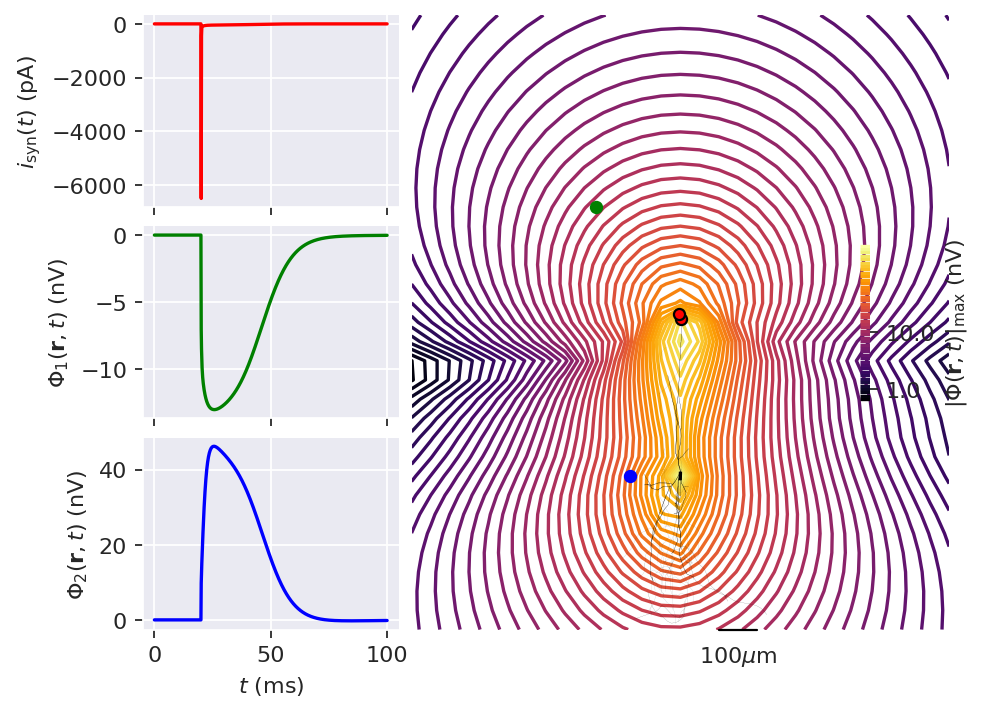

In [7]:
run_expr(int_parameters, int_rotations)

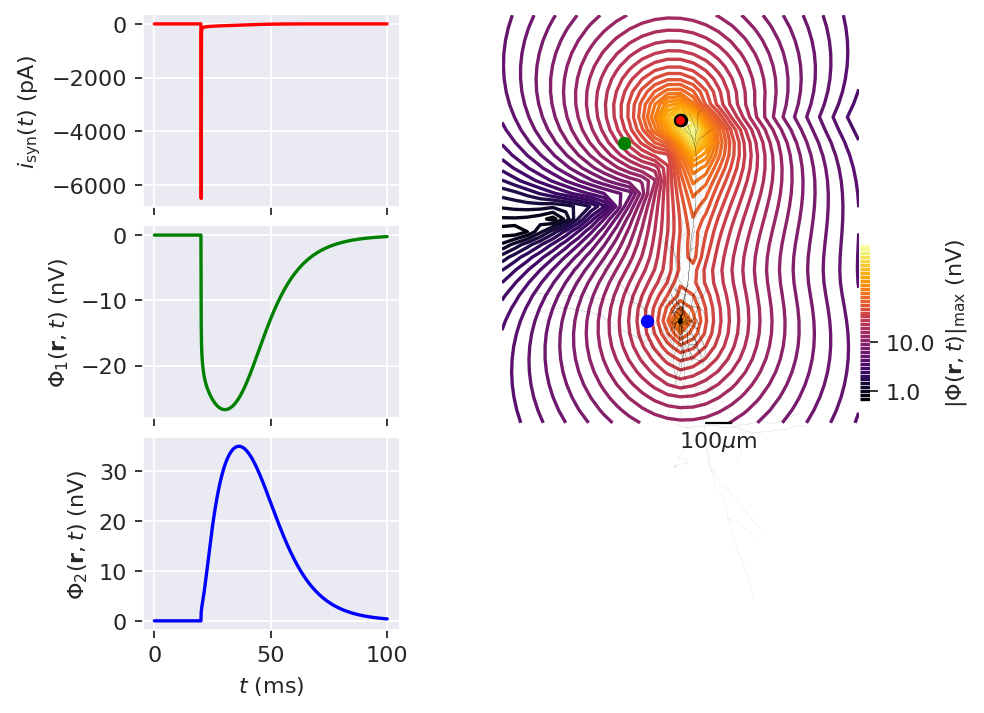

In [10]:
run_expr(pyr_parameters, pyr_rotations)

From the time dependent plots we can observe differences in the extracellular potential at the blue and green electrodes.  

Firstly, both the green electrodes show a decrease in extracellular potential, while the opposite happens for the blue ones. Indeed, the blue electrodes are closer to the dendrite location where positive ions leave the cell, whereas the calcium influx decreases the extracellular potential next to the synapse location. Secondly, we observe a difference in the maximum amplitude of the extracellular potential, but it is hard to draw conclusions on this aspect since the relative position of the electrodes with respect to the neuron is different.  
Furthermore, we note that the pyramidal cell has a longer dynamic: in general, it takes more time to go back to zero (around 50 ms more). This is in line with the fact that inhibitory neurons tend to ripolarize faster.  

Moreover, from the spatial representation of the extracellular potential we observe that it follows the morphologies to a certain extent. Additionnally, there is a stronger augmentation for the pyramidal cell around the synapse. Lastly, the intensity spreads out to a higher extent for the pyramidal neuron and is more localized around the inhibitory one.  


# <font color= 'red'>Ex 3:</font> Sustainability

Consider the environmental impact of the large-scale computing for computational science. Suggest two ways in which the impact of computing can be reduced, include at least one idea of your own (not covered in the lecture). 

<font size='3'><font color= 'red'>[1 pts]</font> 


<span style="color:purple">
<font size='3'> 
    

## **Grading**: 
 - 0.5 pt per suggestion (we will be very lenient in the accepted answers, just make an effort to come up with options and you'll get the points).
    

[/2 pt]    
</span>